# Loading data from the Harvard Art Museums

This script loads all objects in the online collection of the [Harvard Art Museums](https://harvardartmuseums.org/collections).

Requests are parallelized for maximum efficiency. Note that there may be IP-based rate limits on the website, so you won't necessarily be able to download the data at maximum network speed. It shouldn't take more than a few minutes though.

In [4]:
import asyncio
import aiohttp
import sys
import json
import pandas as pd
import numpy as np
import csv

# from aiohttp_retry import RetryClient
from tqdm import tqdm

In [2]:
# async def load_page(client: aiohttp.ClientSession, num: int):
#     offset = 100 * num
#     async with client.get(f'https://harvardartmuseums.org/browse?load_amount=100&offset={offset}') as resp:
#         assert resp.status == 200
#         return await resp.json()

# async def load_data():
#     concurrency = 10

#     records = []
#     sema = asyncio.Semaphore(concurrency)

#     async with aiohttp.ClientSession() as client:
#         client = aiohttp.ClientSession()#RetryClient(client)

#         metadata = (await load_page(client, 0))["info"]
#         n_pages = metadata['pages']
#         print(f"found {metadata['totalrecords']} objects and {n_pages} pages")

#         async def query_task(num: int) -> None:
#             try:
#                 data = await load_page(client, i)
#                 records.extend(data['records'])
#             except Exception as e:
#                 print(f"request failure: {e}", file=sys.stderr)
#             finally:
#                 sema.release()

#         for i in tqdm(range(n_pages)):
#             await sema.acquire()
#             asyncio.create_task(query_task(i))

#     for _ in range(concurrency):
#         await sema.acquire()
    
#     return records

In [3]:
# data = await load_data()

In [10]:
deduped_data = list({record['id']: record for record in data}.values())

print(f"Retrieved {len(data)} records, and {len(deduped_data)} distinct records")

# write data to json
with open("all_data.json", "w") as f:
    json.dump(deduped_data, f)

Retrieved 242754 records, and 234827 distinct records


### read data from json

In [5]:
# read data from json

with open("all_data.json", "r") as f:
    deduped_data = json.load(f)

## analyze all data

In [ ]:
# fields:
#     dated
#     century
#     culture
#     medium
#     colorcount
#     primary color - need to computer, if color count = 0, don't use (?)
#     url - keep track

In [110]:
cols = ['medium', 'dated', 'dateend', 'culture', 'colorcount', 'classification', 'department', 'url']
cols = ['dateend', 'culture', 'colorcount', 'classification', 'department', 'technique']

data = []
colors_all = []
for record in deduped_data:
    r = []
    
    for c in cols:
        r.append(record[c])
    
    if record['colorcount'] == 0:
        colors_all.append('#000000')
    else: colors_all.append(record['colors'][0]['color'])
    
#     # medium
#     r.append(record['medium'])
#     # medium
#     med = record['medium']
#     val = 0
#     if 'canvas' in med:
#         val = 1
#     elif 'paper' in med:
#         val = 2
#     elif 'print' in med:
#         val = 3
#     elif 'photograph' in med:
#         val = 4
#     r.append(val)
    
#     # date
#     date = record['dated']
#     if 'century' in date or date == 'n.d.': r.append(1950)
#     else: r.append(int(date[-4:]))
        
#     r.append(record['culture'])
#     r.append(record['colorcount'])
#     r.append(record['classification'])
#     r.append(record['url'])
    data.append(r)
    
df = pd.DataFrame(data, columns = cols)

In [96]:
# set(df[df['colorcount'] == 2]['url'])

In [78]:
# set(df['technique'])

## acrylic analysis

In [6]:
acrylic = []
for record in deduped_data:
    if record['medium'] and 'acrylic' in record['medium'].lower():
        acrylic.append(record)
        
len(acrylic)

293

In [7]:
data = []
point_colors = []

cols = ['classification', 'dated', 'culture', 'colorcount', 'primary']
cols = ['classification', 'dated', 'culture', 'colorcount', 'primary', 
       'Black', 'Blue', 'Brown', 'Green','Grey','Orange','Red','Violet','White','Yellow']

colors = ['Black', 'Blue', 'Brown', 'Green','Grey','Orange','Red','Violet','White','Yellow']

for record in acrylic:
    r = []
    
    r.append(record['classification'])
    
    r.append(record['dateend']/100)
        
    r.append(record['culture'])
    
    if record['colorcount'] == 0:
        continue
    r.append(record['colorcount'])
    
    # primary color
    r.append(record['colors'][0]['hue'])
    point_colors.append(record['colors'][0]['color'])
    
    col_freq = np.zeros(len(colors))

    for c in record['colors']:
        col_freq[colors.index(c['hue'])] += c['percent']*100
    
    data.append(r + list(col_freq))
    
    
df_embedded = pd.DataFrame(data, columns = cols)

### compute color composition + information of acrylic works

In [100]:
color_composition = []

desc = []
# title = []
# author = []
# date = []
# url = []

i = 0
for record in acrylic:
    
    r_color = []
    if record['colorcount'] == 0:
        continue
    for c in record['colors']:
        if c['percent']*100 > 5:
            r_color.append(c['color'])
            r_color.append(int(c['percent']*100))
    color_composition.append(r_color)
    
    row_desc = []
    row_desc.append(i)
    row_desc.append(record['title'])
    
    if record['peoplecount'] > 0: row_desc.append(record['people'][0]['name'])
    else: row_desc.append('')

    row_desc.append(record['dateend'])
    row_desc.append(record['totalpageviews'])
    row_desc.append(record['url'])
    
    desc.append(row_desc)
    i += 1
    

In [ ]:
interesting_ids = [1, 4, 5, 6, 10, 13, 14, 20, 25, 27, 34, 37, 39, 122, 172, 197]

In [130]:
desc_df.iloc[122]

id                                                      122
title     Wall Drawing #830 (Four Isometric Figures With...
artist                                           Sol LeWitt
date                                                   1997
views                                                   337
url       https://www.harvardartmuseums.org/collections/...
Name: 122, dtype: object

In [103]:
desc_df = pd.DataFrame(desc, columns = ['id', 'title', 'artist', 'date', 'views', 'url'])

In [111]:
desc_df[desc_df['views'] > 520]

,id,title,artist,date,views,url
24,24,Square from Nine Rectangles,Max Bill,1944,530,https://www.harvardartmuseums.org/collections/...
163,163,Corona,Helen Frankenthaler,1979,859,https://www.harvardartmuseums.org/collections/...
201,201,Summer Orange,Joan Snyder,1970,3047,https://www.harvardartmuseums.org/collections/...
203,203,Untitled,Kerry James Marshall,2008,3897,https://www.harvardartmuseums.org/collections/...
212,212,October's Gone...Goodnight,Barkley L. Hendricks,1973,1209,https://www.harvardartmuseums.org/collections/...


In [113]:
desc_df.to_csv('desc.csv', index=False)

In [96]:
acrylic[0]

{'copyright': None,
 'contextualtextcount': 0,
 'creditline': 'Harvard Art Museums/Arthur M. Sackler Museum, Museum Collection',
 'accesslevel': 1,
 'dateoflastpageview': '2022-11-16',
 'classificationid': 30,
 'division': 'Asian and Mediterranean Art',
 'markscount': 0,
 'publicationcount': 0,
 'totaluniquepageviews': 44,
 'contact': 'am_asianmediterranean@harvard.edu',
 'colorcount': 10,
 'rank': 69779,
 'state': None,
 'id': 321166,
 'verificationleveldescription': 'Good. Object is well described and information is vetted',
 'period': None,
 'images': [{'date': '2009-01-14',
   'copyright': 'President and Fellows of Harvard College',
   'imageid': 326541,
   'idsid': 11883373,
   'format': 'image/jpeg',
   'description': None,
   'technique': None,
   'renditionnumber': 'DDC107490',
   'displayorder': 1,
   'baseimageurl': 'https://nrs.harvard.edu/urn-3:HUAM:DDC107490_dynmc',
   'alttext': None,
   'width': 694,
   'publiccaption': 'Color plaster reproduction of 5th century BCE reli

## perform UMAP on data

In [10]:
import umap
# umap documentation: https://github.com/lmcinnes/umap

# from sklearn.datasets import load_digits
# digits = load_digits()
# embedding = umap.UMAP().fit_transform(digits.data)

In [136]:
df_embedded

,classification,dated,culture,colorcount,primary,Black,Blue,Brown,Green,Grey,Orange,Red,Violet,White,Yellow
0,Sculpture,0.00,Achaemenid,10,Grey,0.0,0.000000,0.000000,0.000000,70.567657,2.330033,4.178218,0.000000,0.0,13.405941
1,Paintings,19.61,American,10,Orange,0.0,0.000000,2.748299,1.625850,5.156463,74.789116,5.775510,0.000000,0.0,6.952381
2,Paintings,19.63,American,4,Red,0.0,0.000000,0.004566,0.000000,4.712329,0.000000,95.283105,0.000000,0.0,0.000000
3,Paintings,19.64,American,10,Green,0.0,20.436137,0.000000,57.252336,1.831776,0.000000,0.000000,20.012461,0.0,0.000000
4,Paintings,19.60,American,10,Orange,0.0,0.000000,17.985185,1.259259,0.000000,64.429630,12.281481,0.000000,0.0,2.918519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,Photographs,19.80,American,10,Grey,0.0,12.861111,7.272222,24.238889,41.522222,0.000000,0.000000,0.000000,0.0,0.000000
239,Photographs,19.95,American,10,Grey,0.0,0.000000,24.882353,0.000000,53.490196,0.000000,16.026144,0.000000,0.0,0.000000
240,Drawings,19.95,American,10,Orange,0.0,24.576923,4.743590,0.000000,3.416667,36.942308,6.705128,6.583333,0.0,0.000000
241,Photographs,19.98,American,10,Grey,0.0,0.061728,21.913580,0.000000,78.024691,0.000000,0.000000,0.000000,0.0,0.000000


(array([ 3.,  3., 12., 36., 24., 25., 22., 86., 18.,  5.]),
 array([19.44 , 19.509, 19.578, 19.647, 19.716, 19.785, 19.854, 19.923,
        19.992, 20.061, 20.13 ]),
 <BarContainer object of 10 artists>)

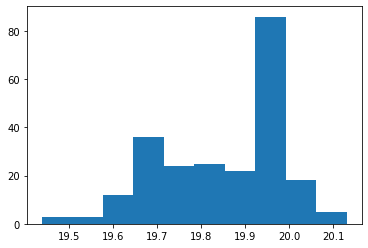

In [139]:
plt.hist(df_embedded[df_embedded['dated'] > 15]['dated'])

In [141]:
df_embedded[df_embedded['dated'] == 0]

,classification,dated,culture,colorcount,primary,Black,Blue,Brown,Green,Grey,Orange,Red,Violet,White,Yellow
0,Sculpture,0.0,Achaemenid,10,Grey,0.000000,0.000000,0.000000,0.000000,70.567657,2.330033,4.178218,0.0,0.000000,13.405941
11,Drawings,0.0,Spanish,4,Black,32.820144,0.000000,0.000000,0.000000,67.179856,0.000000,0.000000,0.0,0.000000,0.000000
12,Drawings,0.0,Spanish,8,Grey,8.963585,0.000000,0.000000,0.000000,75.193277,0.000000,0.000000,0.0,15.843137,0.000000
17,Drawings,0.0,American,10,Blue,24.034783,65.217391,0.220290,0.000000,0.000000,5.646377,4.301449,0.0,0.000000,0.185507
29,Paintings,0.0,American,10,Green,0.000000,27.884848,0.000000,41.339394,18.060606,0.000000,0.000000,0.0,0.000000,0.000000
194,Paintings,0.0,American,10,Red,0.000000,4.938667,0.000000,31.834667,0.000000,26.890667,35.589333,0.0,0.000000,0.000000
206,Paintings,0.0,American,4,Green,0.000000,0.000000,0.000000,99.112994,0.887006,0.000000,0.000000,0.0,0.000000,0.000000
222,Paintings,0.0,American,10,Grey,0.000000,0.000000,0.000000,45.641873,49.415978,0.000000,0.000000,0.0,0.000000,0.000000
231,Paintings,0.0,American,10,Brown,0.000000,3.083333,70.317708,13.140625,0.000000,0.000000,8.750000,0.0,4.536458,0.171875


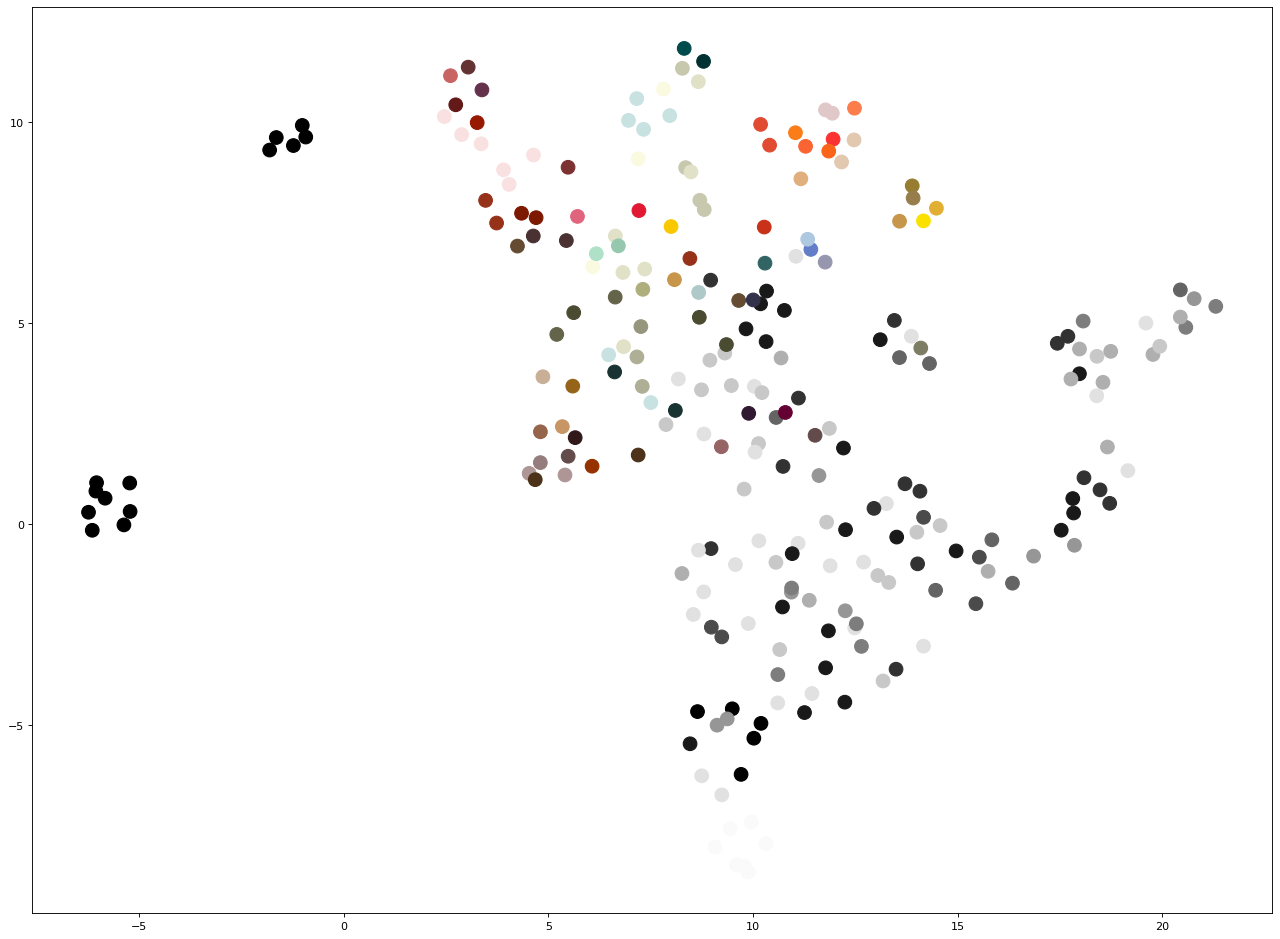

In [73]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# mixed-type datasets: https://github.com/lmcinnes/umap/issues/58
binarized = pd.get_dummies(df_embedded)

umap_embedding_acrylic = umap.UMAP(n_neighbors = 5, min_dist = 0.99, metric='manhattan').fit_transform(binarized)

figure(figsize=(20, 15), dpi=80)

plt.scatter(umap_embedding_acrylic[:, 0], umap_embedding_acrylic[:, 1], color = point_colors, s = 150)

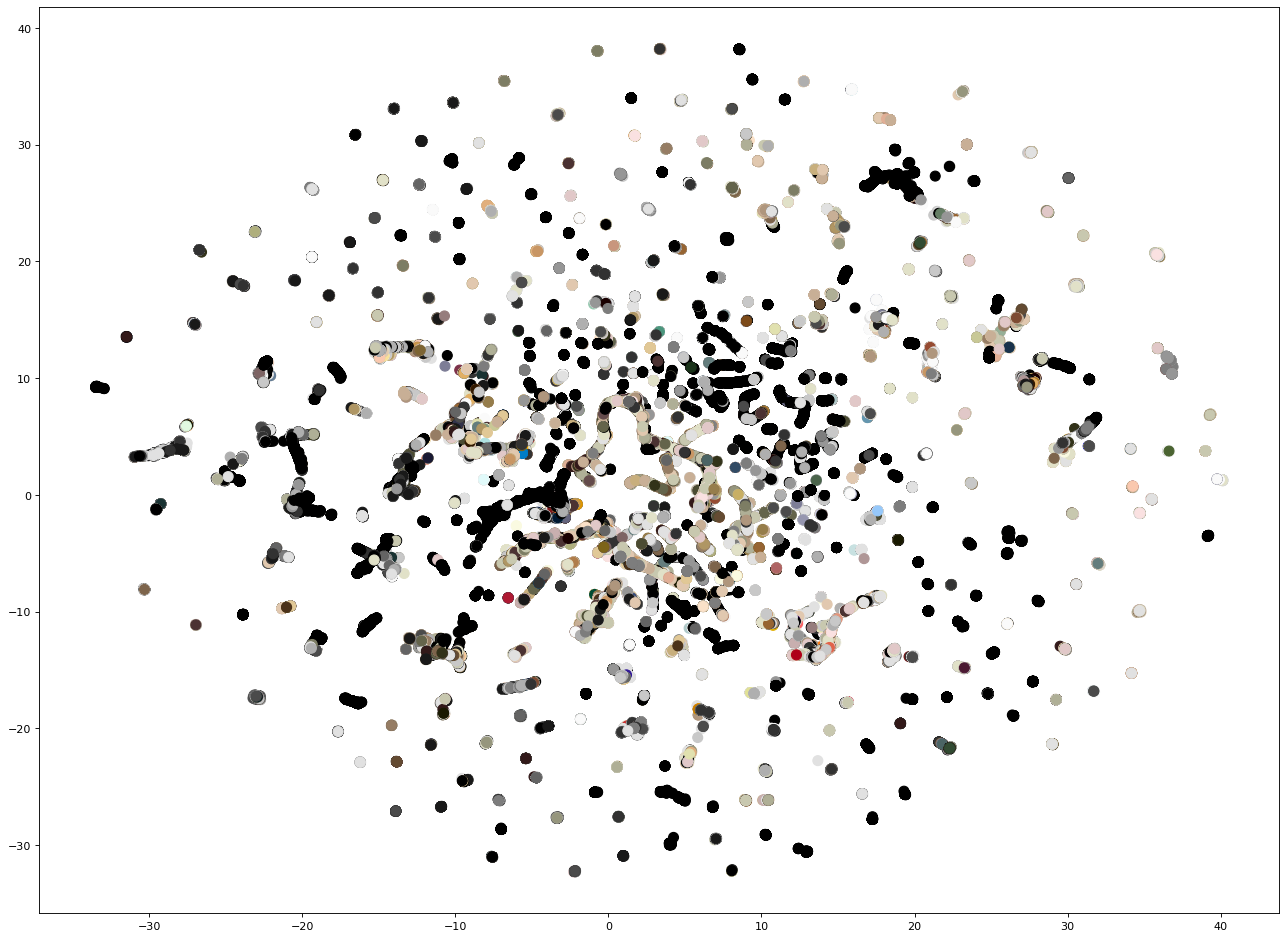

In [114]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

bin_all = pd.get_dummies(df)

umap_embedding_acrylic = umap.UMAP(n_neighbors = 25, min_dist = 0.01).fit_transform(binarized)

figure(figsize=(20, 15), dpi=80)

plt.scatter(umap_embedding_all[:, 0], umap_embedding_all[:, 1], color = colors_all, s = 80)

### export coordinate/color data to csvs

In [74]:
from lloyd import Field

# lloyd relaxation
# https://stackoverflow.com/questions/51214496/python-ensure-each-pairwise-distance-is-some-minimum-distance
# https://douglasduhaime.com/posts/lloyd-iteration.html

field = Field(umap_embedding_acrylic)
for i in range(150):
    field.relax()
    
transformed = field.get_points()
x = transformed[:, 0]
transformed[:, 0] = (x - min(x))/(max(x) - min(x))
y = field.get_points()[:, 1]
transformed[:, 1] = (y - min(y))/(max(y) - min(y))

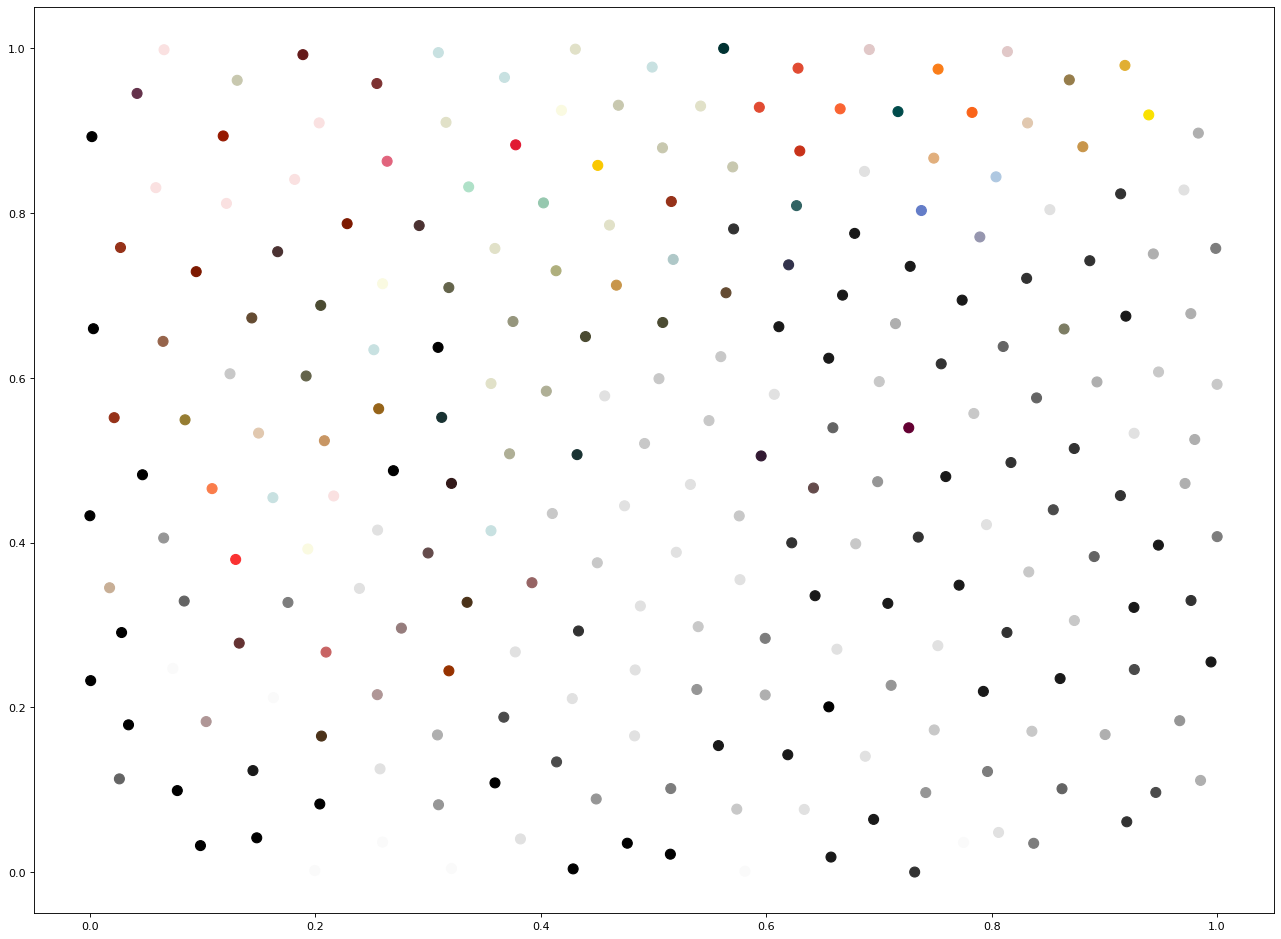

In [75]:
figure(figsize=(20, 15), dpi=80)

plt.scatter(transformed[:, 0], transformed[:, 1], color = point_colors, s = 80)

In [76]:
with open("color_comp.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(color_composition)

In [77]:
with open("coordinates.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(transformed)

In [67]:
len(color_composition)

243

In [132]:
title.index('The Carillons of Noon')

25

In [134]:
desc[110]

[110,
 'Symbolism Series I',
 'Dan Namingha',
 1994,
 104,
 'https://www.harvardartmuseums.org/collections/object/310459']

In [135]:
acrylic[0]

{'copyright': None,
 'contextualtextcount': 0,
 'creditline': 'Harvard Art Museums/Arthur M. Sackler Museum, Museum Collection',
 'accesslevel': 1,
 'dateoflastpageview': '2022-11-16',
 'classificationid': 30,
 'division': 'Asian and Mediterranean Art',
 'markscount': 0,
 'publicationcount': 0,
 'totaluniquepageviews': 44,
 'contact': 'am_asianmediterranean@harvard.edu',
 'colorcount': 10,
 'rank': 69779,
 'state': None,
 'id': 321166,
 'verificationleveldescription': 'Good. Object is well described and information is vetted',
 'period': None,
 'images': [{'date': '2009-01-14',
   'copyright': 'President and Fellows of Harvard College',
   'imageid': 326541,
   'idsid': 11883373,
   'format': 'image/jpeg',
   'description': None,
   'technique': None,
   'renditionnumber': 'DDC107490',
   'displayorder': 1,
   'baseimageurl': 'https://nrs.harvard.edu/urn-3:HUAM:DDC107490_dynmc',
   'alttext': None,
   'width': 694,
   'publiccaption': 'Color plaster reproduction of 5th century BCE reli